In [ ]:
#from structure import structure
import numpy as np
import matplotlib.pyplot as plt
from geometry import Point
from pprint import pprint
from mpl_toolkits.mplot3d import Axes3D
import time
from copy import deepcopy
import pickle
import networkx as nx
from matplotlib import cm
import matplotlib.colors as mcolors
%matplotlib notebook

In [92]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from copy import deepcopy
from matplotlib.tri import Triangulation

from geometry import *
from kmeans import *

class structure(object):
    def __init__(self, n_nodes, in_area, sigma = 1,
                 xlim=[-1,1], ylim=[-1,1],  
                 n_sec_max = 100, multiplier=10, 
                 dont_print = True,
                 depth_limit = 3):
        self.dont_print = dont_print
        if n_nodes<4:
            print("error, n_nodes<1")
        self.xlim = list(xlim)
        self.ylim = list(ylim)
        self.in_area = in_area
        self.n_nodes = n_nodes
        self.G = nx.Graph()
        self.p=[]
        self.boundary_nodes = set()
        
        self.sigma = sigma
        
        self.depth_limit = depth_limit
        self.n_per_section = 0
        
    def make_points(self, n_sec_max=100, multiplier =10):
        p=[]
        sections = 1
        not_enough = True
        while not_enough:
            if self.n_nodes/sections**2<n_sec_max:
                not_enough = False
            else:
                sections+=1
        self.n_per_section = int(self.n_nodes/sections**2)
        for i in range(sections):
            y_lim = (self.ylim[0]+i/sections*(self.ylim[1]-self.ylim[0]),
                     self.ylim[0]+(i+1)/sections*(self.ylim[1]-self.ylim[0]))
            for j in range(sections):
                x_lim = (self.xlim[0]+j/sections*(self.xlim[1]-self.xlim[0]),
                         self.xlim[0]+(j+1)/sections*(self.xlim[1]-self.xlim[0]))
                
                points = []
                for n in range(self.n_per_section*multiplier):
                    a, b = np.random.random(size = 2)
                    position = np.array([x_lim[0]+ a*(x_lim[1]-x_lim[0]), y_lim[0]+ b*(y_lim[1]-y_lim[0])])    
                    points.append(position)
                
                cp = find_centers(points, self.n_per_section, iter_max=2)  #np.random.random(size = (N,2)))
                filtered_centers = []
                for point in cp[0]:
                    if self.in_area(point):
                        filtered_centers.append(point)
                p = p + filtered_centers
        print("Number of points:", len(p))
        self.n_nodes = len(p) 
        for id_n,point in enumerate(p):
            self.p.append(Point(point[0], point[1]))
    def make_points_simple(self):
        n_boundary = int(np.sqrt(self.n_nodes))
        dy = (self.ylim[1]-self.ylim[0])/n_boundary/5
        x0 = np.ones(n_boundary)*self.xlim[0]
        y0 = np.linspace(self.ylim[0]+dy, self.ylim[1]-dy, n_boundary)
        
        x1 = np.ones(n_boundary)*self.xlim[1]
        y1 = np.linspace(self.ylim[0]+dy, self.ylim[1]-dy, n_boundary)
        
        x2 = np.linspace(self.xlim[0], self.xlim[1], n_boundary)
        y2 = np.ones(n_boundary)*self.ylim[0]
        
        x3 = np.linspace(self.xlim[0], self.xlim[1], n_boundary)
        y3 = np.ones(n_boundary)*self.ylim[1]
        
        restx = np.random.random(size = self.n_nodes-n_boundary*4)*(self.xlim[1]-self.xlim[0])+self.xlim[0]
        resty = np.random.random(size = self.n_nodes-n_boundary*4)*(self.ylim[1]-self.ylim[0])+self.ylim[0]
        self.X = np.concatenate((x0,x1,x2,x3,restx))
        self.Y =  np.concatenate((y0,y1,y2,y3,resty))
        self.p = [Point(self.X[i],self.Y[i]) for i in range(self.n_nodes)]
        self.boundary_nodes = list(range(n_boundary*4))
        
    def make_graph(self):
        self.T = Triangulation(self.X,self.Y)
        self.G = nx.Graph()
        self.G.add_edges_from(self.T.edges)
        #self.boundary_check2(list(self.G.nodes()))
        
    def improve_points(self):
        for i in self.G.nodes():
            if not i in self.boundary_nodes:
                x = 0
                y = 0
                n = 0
                for j in self.G.neighbors(i):
                    x += self.X[j]
                    y += self.Y[j]
                    n += 1
                x = x/n
                y = y/n
                self.X[i]= x
                self.Y[i]= y
                self.p[i] = Point(x,y)
        
    def find_closest_inside_graph(self, i, other_than, pool = -1):
        if pool == -1:
            pool = list(self.G.nodes())
        actual_pool = []
        for i in pool:
            if i not in other_than:
                actual_pool.append(i)
                
        if len(actual_pool)>0:
            minj = np.random.choice(actual_pool)
            for j in actual_pool:
                if self.p[i].distance(self.p[j])<self.p[i].distance(self.p[minj]):
                    minj = j
            return minj
        else:
            return -1
        

    def find_closest_inside_graph_fast(self, i, pi):
        pool = list(self.G.nodes())        
        if len(pool)>0:
            closest_found = []
            for k in range(5):
                minj = np.random.choice(pool)
                found = False
                while not found:
                    nodes = self.G.neighbors(minj)
                    new_minj = minj
                    for j in nodes:
                        if pi.distance(self.p[j])<pi.distance(self.p[minj]):
                            if i!=j:
                                new_minj = j
                    if minj==new_minj:
                        found = True
                    else:
                        minj=new_minj
                closest_found.append(minj)
            if not self.dont_print: print("find_closest_fast: closest_found, ", closest_found)
            minj = closest_found[0]
            for j in closest_found[1:]:
                if pi.distance(self.p[j])<pi.distance(self.p[minj]):
                    minj = j
            return  minj
        else:
            return -1
    def draw_points(self, ):
        fig,ax = plt.subplots(figsize =(8,8))
        plt.scatter([p.x for p in self.p],[p.y for p in self.p])
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
    
    def draw_graph(self, ax = -1, **kwargs ):
        pos = {node:(self.p[node].x,self.p[node].y) for node in self.G.nodes()}
        
        color = []
        for i in range(len(self.p)):
            if i in self.boundary_nodes: 
                color.append("r")
            else:
                color.append("b")
        my_figure = False
        if ax == -1:
            my_figure = True
            fig,ax = plt.subplots(figsize =(8,8))
        nx.draw_networkx(self.G, 
                         pos = pos,
                         node_color = color, 
                         #node_size = 180,
                         #with_labels= True,
                         #font_size = 17,
                         **kwargs)
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
        
        if my_figure: plt.show()
        
    def reconnect_all_spatially(self, pool=None, check_boundary = True, with_edge=False):
        if pool == None:
            pool = self.G.nodes()
            
        for i in pool:
            self.reconnect_spatially(i,check_boundary = check_boundary, with_edge=False)
    
    def reconnect_spatially(self, i, with_proxy = False, proxy = 0, with_edge=False, last = False, check_boundary = True):
        if not self.dont_print: print("reconnect_spatially:\n i,",i,
                                      ", with_proxy, ", with_proxy,
                                      ",proxy,",  proxy,
                                      " with_edge,", with_edge,
                                      " last,", last,
                                      "check_boundary, ",check_boundary)
        if with_proxy:
            neighbours = list(nx.all_neighbors(self.G, i))
            if neighbours!=[]:
                for j in neighbours:
                    self.G.remove_edge(i,j)
            #its a solo point:
            other_than = [i, proxy]
            
            close_nodes=set()
            for e in nx.dfs_edges(self.G, source= proxy, depth_limit = self.depth_limit):
                close_nodes.add(e[1])
            if with_edge:
                close_nodes = close_nodes.union(self.boundary_nodes)
            close_nodes = list(close_nodes)
            no_of_edges = 1
            end_of_nodes = False
            while no_of_edges<6 and not end_of_nodes:
                j = self.find_closest_inside_graph(i, other_than, pool = close_nodes)
                if j != -1:
                    other_than.append(j)
                else:
                    end_of_nodes = True
                    
            for j in other_than[1:]:
                self.G.add_edge(i,j)
            self.reconnect_properly_depth(i,check_boundary = check_boundary, last = last)
            
        else:
            neighbours = list(nx.all_neighbors(self.G, i))
            if neighbours!=[]:
                for j in neighbours:
                    self.G.remove_edge(i,j)
            #its a solo point:
            other_than = [i]
            no_of_edges = 0
            end_of_nodes = False
            while no_of_edges<6 and not end_of_nodes:
                j = self.find_closest_inside_graph(i, other_than)
                if j != -1:
                    other_than.append(j)
                else:
                    end_of_nodes = True
            for j in other_than[1:]:
                self.G.add_edge(i,j)
            self.reconnect_properly_depth(i,check_boundary = check_boundary, last = last)
        
    def reconnect_properly_depth(self, i, depth_limit = -1, last = False, check_boundary = True, with_edge=False):
        if not self.dont_print: print("reconnect_properly_depth:\n i, ",i,
                                      ", depth_limit, ", depth_limit,
                                      ", last, ", last,
                                      ", check_boundary, ",check_boundary,
                                      ", with_edge, ", with_edge)
        
        if depth_limit ==-1:
            depth_limit = self.depth_limit
        close_nodes=set()
        for e in nx.dfs_edges(self.G, source= i, depth_limit = depth_limit):
            close_nodes.add(e[1])
        if with_edge:
            close_nodes = close_nodes.union(self.boundary_nodes)
        close_nodes= list(close_nodes)
        self.reconnect_properly(i,close_nodes, last= last, check_boundary= check_boundary)
        
    def reconnect_properly(self, i,  pool, last = False, check_boundary = True):
        if not self.dont_print: print("reconnect_properly:\n i, ",i,
                                      ", pool, ", pool,
                                      ", last, ", last,
                                      ", check_boundary, ",check_boundary)
        if pool == []:
            self.reconnect_spatially(i, last = last, check_boundary = check_boundary)
        else:
            points = []
            for cn in pool:
                try:
                    points.append(self.p[cn])
                except:
                    print("error, reconnect properly", pool)
            poli = Poligon(self.p[i])
            
            poli.load_dots(points, pool)
            poli.produce_lines_from_dots()

            redundant_names = poli.kick_redundant_dots_lines()
            b_check=[]
            lost_all_edges = []
            may_have_too_many_edges=[]
            for j in pool:
                if j in redundant_names:# or self.p[j].distance(self.p[i])>self.sigma*10:
                    if self.G.has_edge(i,j):
                        self.G.remove_edge(i, j)
                        if list(self.G.neighbors(j)) == []:
                            lost_all_edges.append(j)
                else:
                    self.G.add_edge(i, j)
                    b_check.append(j)
                    may_have_too_many_edges.append(j)
                    
            for j in set(may_have_too_many_edges):
                if not last: 
                    self.reconnect_properly_depth(j,depth_limit=1, last = True ,check_boundary = check_boundary)
            for j in set(lost_all_edges):
                self.reconnect_spatially(j ,check_boundary = check_boundary, last = last)
            
            if check_boundary:
                self.boundary_check(b_check)
                if self.on_edge(i):
                    self.boundary_nodes.add(i)
    
    def reconnect_all_properly(self, last = False, check_boundary = True):
        for i in self.G.nodes():
            self.reconnect_properly_depth(i,check_boundary = check_boundary, last = last)
    
    def on_edge(self, i):
        if not self.dont_print: print("On edge started, point ", i)
        
        # check if it is on edge
        # it is on the edge if any of the limiting lines is not redundant.
        neighbours = list(nx.all_neighbors(self.G, i))
        points = []
        for neighbour in neighbours:
            points.append(self.p[neighbour])
        
        add_points = [Point(2*self.xlim[0]-self.p[i].x, self.p[i].y),
                      Point(2*self.xlim[1]-self.p[i].x, self.p[i].y),
                      Point(self.p[i].x, 2*self.ylim[0]-self.p[i].y),
                      Point(self.p[i].x, 2*self.ylim[1]-self.p[i].y)]
        for j, a_p in enumerate(add_points):    
            a_p_name = -j-1
            poli = Poligon(self.p[i])
            poli.load_dots([a_p]+points, [a_p_name]+neighbours)
            poli.produce_lines_from_dots()
        
            redundant_names = poli.kick_redundant_dots_lines()
            if not self.dont_print: print(a_p_name)
            if a_p_name not in redundant_names:
                if not self.dont_print: print("point ", i , " is on edge ",a_p_name, a_p.x, a_p.y)
                return True
        return False
    
    def boundary_check2(self,pool):
        for i in pool:
            oe = self.on_edge(i)
            if i in self.boundary_nodes:
                if not oe:
                    self.boundary_nodes.remove(i)
            else:
                if oe:
                    self.boundary_nodes.add(i)
    def boundary_check(self,pool):
        for i in pool:
            if i in self.boundary_nodes:
                oe = self.on_edge(i)
                if not oe:
                    self.boundary_nodes.remove(i)
    
    def limit_check(self, x,y):
        if x<self.xlim[0]:
            self.xlim[0] = x-self.sigma
        if x>self.xlim[1]:
            self.xlim[1] = x+self.sigma
        if y<self.ylim[0]:
            self.ylim[0] = y-self.sigma
        if y>self.ylim[1]:
            self.ylim[1] = y+self.sigma
                
    def rescale_one(self, i, old_xlim, old_ylim, old_hlim, new_xlim, new_ylim, new_hlim):
        if old_hlim[0]!=old_hlim[1]:
            self.h[i] = new_hlim[0]+(self.h[i]-old_hlim[0])/(old_hlim[1]- old_hlim[0])*(new_hlim[1]- new_hlim[0])
            self.wl[i] = new_hlim[0]+(self.wl[i]-old_hlim[0])/(old_hlim[1]- old_hlim[0])*(new_hlim[1]- new_hlim[0])
        self.p[i].x = new_xlim[0]+(self.p[i].x-old_xlim[0])/(old_xlim[1]- old_xlim[0])*(new_xlim[1]- new_xlim[0])
        self.p[i].y = new_ylim[0]+(self.p[i].y-old_ylim[0])/(old_ylim[1]- old_ylim[0])*(new_ylim[1]- new_ylim[0])
        
    def rescale(self,new_xlim, new_ylim, new_hlim):
        old_xlim = deepcopy(self.xlim)
        old_ylim = deepcopy(self.ylim)
        try:
            old_hlim = [min(self.h), max(self.h)]
        except:
            old_hlim = [0,0]
        for i in self.G.nodes():
            self.rescale_one(i, old_xlim, old_ylim, old_hlim, new_xlim, new_ylim, new_hlim)
            
        self.xlim = new_xlim
        self.ylim = new_ylim
        
        

In [82]:
n_nodes = 10000
area = lambda x: True

s = structure(n_nodes, area, sigma = 1,
                 xlim=[-1,1], ylim=[-1,1],  
                 n_sec_max = 100, multiplier=10, 
                 dont_print = True,
                 depth_limit = 3)

In [66]:
s.make_points_simple()
print("Made points")
s.make_graph()
print("Made graph")

Made points
Made graph


<IPython.core.display.Javascript object>


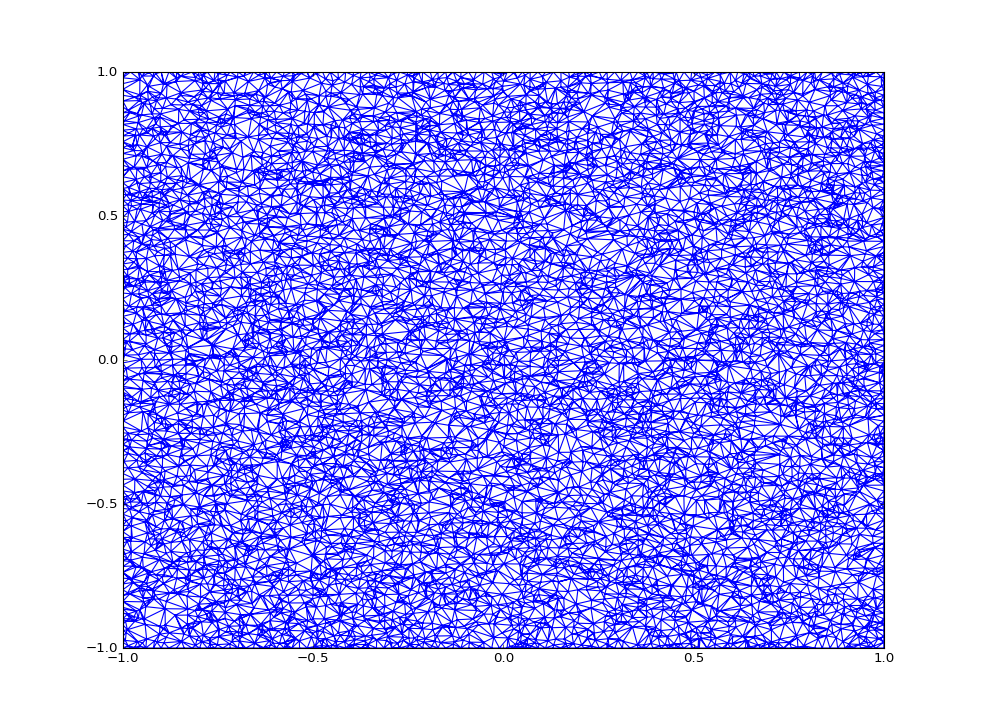

In [67]:
fig,ax = plt.subplots()
ax.triplot(s.T)
plt.show()

In [70]:
for i in range(10):
    s.improve_points()

<IPython.core.display.Javascript object>


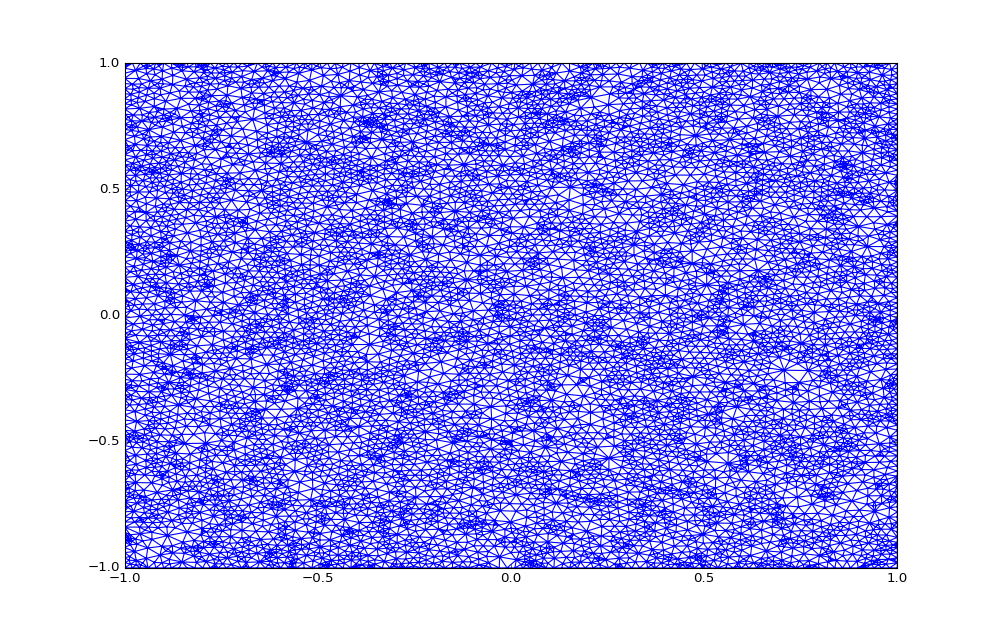

In [71]:
fig,ax = plt.subplots()
ax.triplot(s.T)
plt.show()

In [221]:
class map_generator(structure):
    def __init__(self, n_nodes, area, 
                 h_sigma, sigma = 1,
                 h_picture=50,w_picture=50,
                 xlim=[-1,1], ylim=[-1,1], hlim =[-1,1],
                 n_sec_max = 100, multiplier=10, 
                 dont_print = True,
                 depth_limit = 3):
        structure.__init__(self,n_nodes, area, 
                           sigma = sigma,
                           xlim=xlim, ylim=ylim,  
                           n_sec_max = n_sec_max, multiplier=multiplier, 
                           dont_print = dont_print,
                           depth_limit = 3)
        self.hlim = hlim
        
        self.make_points_simple()
        print("Made points.")
        self.make_graph()
        print("Made graph.")
        for i in range(10):
            self.improve_points()
        self.h_pic = h_picture
        self.w_pic = w_picture
        
        self.h_sigma= h_sigma
        
        self.h = [0 for i in self.G.nodes()]
        self.wl = [0 for i in self.G.nodes()]
        self.flux = [0 for i in self.G.nodes()]
        
        self.growth_rate = np.ones(n_nodes)
        
        self.lakes = []

    def elevation_picture(self):
        mapa = np.zeros([self.h_pic,self.w_pic])

        for i in range(self.h_pic):
            for j in range(self.w_pic):
                x,y = self.coord_from_ij(i,j)
                mapa[i,j] = self.h[self.find_closest_inside_graph_fast(n_nodes+1, Point(x,y))]
        return mapa
    
    def water_level_picture(self):
        mapa = np.zeros([self.h_pic,self.w_pic])

        for i in range(self.h_pic):
            for j in range(self.w_pic):
                x,y = self.coord_from_ij(i,j)
                mapa[i,j] = self.wl[self.find_closest_inside_graph_fast(n_nodes+1, Point(x,y))]
        return mapa
    
    def coord_from_ij(self,i,j):
        x = self.xlim[0]+j*1.0/self.w_pic*(self.xlim[1]-self.xlim[0])
        y = self.ylim[0]+i*1.0/self.h_pic*(self.ylim[1]-self.ylim[0])
        return x,y
    
    def draw_map_h(self, ax = None):
        mapa = self.elevation_picture()
        if ax is None:
            plt.imshow(mapa, cmap="terrain", origin = "lower", vmin = -self.h_sigma, vmax = 6*self.h_sigma)
        else:
            ax.imshow(mapa, cmap="terrain", origin = "lower", vmin = -self.h_sigma, vmax = 6*self.h_sigma)

    def draw_map_wl(self, ax = 0):
        mapa = self.water_level_picture()
        if ax == 0:
            plt.imshow(mapa, cmap="terrain", origin = "lower", vmin = -self.h_sigma, vmax = 6*self.h_sigma)
        else:
            ax.imshow(mapa, cmap="terrain", origin = "lower", vmin = -self.h_sigma, vmax = 6*self.h_sigma)
        
    def draw_model(self, ax = None, **kwargs):
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            X = np.arange(self.xlim[0], self.xlim[1], self.w_pic)
            Y = np.arange(self.ylim[0], self.ylim[1], self.h_pic)
            X, Y = np.meshgrid(X, Y)
            Z = self.elevation_picture()
            #print(X.shape, Y.shape, Z.shape)
            ax.plot_surface(X, Y, Z, **kwargs)
            plt.show()
        else:
            X = np.linspace(self.xlim[0], self.xlim[1], self.w_pic)
            Y = np.linspace(self.ylim[0], self.ylim[1], self.h_pic)
            X, Y = np.meshgrid(X, Y)
            Z = self.elevation_picture()
            
            #print(X.shape, Y.shape, Z.shape)
            ax.plot_surface(X, Y, Z, **kwargs)
    
    def draw_model_triangles(self, ax = None, h=False,**kwargs):
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
        if h: Z = self.h
        else: Z = self.wl
        
        ax.plot_trisurf(self.T, Z,
                        cmap=cm.terrain,
                        vmin = min(Z), vmax = max(Z), 
                        antialiased = True,
                        linewidth = 1,
                        edgecolor = "none",
                        **kwargs)
    def draw_map_tri(self):
        fig, ax = plt.subplots(figsize = (10,10))
        ax.tricontourf(self.X, self.Y, np.array(self.wl), triangles = self.T.triangles, edgecolors = "k" ,
                       vmin = 0, vmax = self.hlim[1], cmap = "terrain")
        average_river = np.average(self.flux)
        print(average_river)
        max_river = np.max(self.flux)
        min_river = np.min(self.flux)
        print(max_river)
        norm = mcolors.Normalize(vmin = min_river, vmax = max_river)
        colors = cm.ScalarMappable(norm=norm, cmap="PuBu")

        for i in self.G.nodes():
            if self.flux[i]>average_river/2:
                j = self.flux_direction[i]
                if i!=-1 and j!=-1:
                    ax.plot([self.X[i], self.X[j]], 
                            [self.Y[i], self.Y[j]], 
                            c = colors.to_rgba(self.flux[i]))
        for l in self.lakes:
            x= []
            y =[]
            for i in l["points"]:
                x.append(self.p[i].x)
                y.append(self.p[i].y)

            if len(x)>3:
                ax.triplot(x,y, c="k")
            elif len(x)==2:
                ax.plot(x,y, c ="k")
            else:
                ax.scatter(x,y, c ="k")
        #triangulation = m.T)#, Z = m.h)
        plt.show()

            
    def check_wl_h(self,i):
        if self.h[i]>self.wl[i]:
            self.wl[i]=self.h[i]
            
    def randomize(self, h_sigma = None):
        if h_sigma != None:
            self.h_sigma = h_sigma    
        self.h = list(np.random.normal(self.h_sigma, size=self.n_nodes))
        self.wl= deepcopy(self.h)
    def grow(self,n):        
        for r in np.random.choice(len(self.h), size = [n]):
            if self.growth_rate[r]>0:
                inc = (self.hlim[1]-self.h[r])*np.random.random()*0.5
                self.h[r]+=inc*self.growth_rate[r]
                self.check_wl_h(r)
                for cn in self.G.neighbors(r):
                    self.h[cn]+= (self.hlim[1]-self.h[cn])*np.random.random()*0.25*self.growth_rate[cn]
                    self.check_wl_h(cn)
            else:
                inc = (self.h[r]-self.hlim[0])*np.random.random()*0.5
                self.h[r]+=inc*self.growth_rate[r]
                self.check_wl_h(r)
                for cn in self.G.neighbors(r):
                    self.h[cn]+= (self.h[cn]-self.hlim[1])*np.random.random()*0.25*self.growth_rate[cn]
                    self.check_wl_h(cn)
    def set_sea(self):
        self.ocean = {"points":set(),
                      "water_level": 0,
                      "shore":set(),
                      "influx":0,
                      "outflux_node": None}
        
            
        for i in self.boundary_nodes:
            self.h[i]=self.hlim[0]
            self.wl[i]=0
            self.ocean["points"].add(i)
            self.ocean["shore"].update(set(self.G.neighbors(i)))
            i_in_lake = self.point_in_some_lake(i)
            if i_in_lake[0]:
                lake=self.lakes.pop(i_in_lake[1])
                
        self.ocean["shore"].difference_update(self.ocean["points"])
        
        swallowed_more = True
        while swallowed_more:
            swallowed_more = self.does_sea_swallow_more()
        
    def does_sea_swallow_more(self):
        swallowed = set()
        possible_shore_add = set()
        for i in self.ocean["shore"]:
            if self.h[i]<0:
                swallowed.add(i)
                possible_shore_add.update(set(self.G.neighbors(i)))
        
        self.ocean["points"].update(swallowed)
        self.ocean["shore"].update(possible_shore_add)
        self.ocean["shore"].difference_update(self.ocean["points"])
        
        if not self.dont_print:print("sea swallowed ", swallowed)
        if not self.dont_print:print("new possible shore points ", possible_shore_add)
        return swallowed!=set()
            
    def lake_influx(self,l):
        #sum influx from the boundary
            #if its in the lake, whole lake influx goes to the current lake
            #else just the flux of that point
        #add number of points of the lake to it.
        influx = 0
        influx = len(self.lakes[l]["points"])
        for node in self.lakes[l]["shore"]:
            if self.flux_direction[node] in self.lakes[l]["points"]:
                in_lake = self.point_in_some_lake(node)
                if in_lake[0]:
                    influx = influx + self.lakes[in_lake[1]]["influx"]
                else:
                    influx = influx + self.flux[node]
        return influx
    
    def ordering_wl(self,item):
        if item[0]=="lake":
            return self.lakes[item[1]]["water_level"]
        elif item[0] == "running":
            return self.wl[item[1]]
        
    def set_flux(self):
        #rain falls uniformely
        self.flux = [1 for i in range(self.n_nodes)]
        self.flux_direction = [-1 for i in range(self.n_nodes)]
        #go from highest to lowest, skip the boundary nodes:
        #go through lakes too.
        running = []
        running = set(range(self.n_nodes)).difference(self.ocean["points"])
        for lake in self.lakes:
            running.difference_update(lake["points"])
        order = []
        for lake_index in range(len(self.lakes)):
            order.append(("lake", lake_index))
            
        for node in running:
            order.append(("running", node))
        order = list(order)
        order.sort(key = self.ordering_wl, reverse = True) #highest to lowest
        new_lake_made = False
        for item in order:
            #add the flux of current point to lowest neighbour, if neighbour is lower.
            #else it is a lake => add its influx to the flux of the outflux node
            if item[0]=="running":
                lowest_neighbour = min(self.G.neighbors(item[1]), key = lambda j: self.h[j])
                if self.h[lowest_neighbour]<self.h[item[1]]:
                    self.flux[lowest_neighbour]+= self.flux[item[1]]
                    self.flux_direction[item[1]] = lowest_neighbour
                else:
                    added = self.add_lake(item[1])
                    if added:
                        new_lake_made = True
            else:
                on = self.lakes[item[1]]["outflux_node"]
                if on!=-1:
                    self.flux[on]+=self.lake_influx(item[1])
                else:
                    print("Error: Lake {0} does not have outflux_node.".format(item[1]))
                    print("nlakes", len(self.lakes))
                    for l in self.lakes:
                        pprint(l)
        if new_lake_made:
            print("New lakes made in set_flux.")
        return new_lake_made
        
    def add_lake(self, i):
        """adds lake and returns True if it did.
        """
        in_lake = self.point_in_some_lake(i) 
        if not in_lake[0]:
            self.lakes.append({"points":set([i]),
                               "water_level": self.h[i],
                               "shore":set([j for j in self.G.neighbors(i)]),
                               "influx":self.flux[i],
                               "outflux_node": -1})
        return not in_lake[0]
    
    def point_in_some_lake(self,i):
        for j, lake in enumerate(self.lakes):
            if i in lake["points"]:
                return True, j
        else:
            return False, -1
    
    def fill_lakes(self):
        #reset water levels first!
        self.wl = deepcopy(self.h)
        #set sea
        self.set_sea()
        #use remaining lakes
        
        for i in range(len(self.lakes)):
            self.lakes[i]["water_level"] = self.h[max(self.lakes[i]["points"], key = lambda i : self.h[i])]
        if not self.dont_print: print("Reset of the water levels done.")
        
        self.lakes.sort(key = lambda lake:lake["water_level"])
        i=0
        
        while i<len(self.lakes):
            if self.lakes[i]["outflux_node"]==-1:
                
                #get a set of points that are on the edge - shore
                shore = self.lakes[i]["shore"]
                #get the lowest among them
                lowest_node = min(shore, key = lambda node: self.h[node])
                lowest_node_in_lake = self.point_in_some_lake(lowest_node)
                #printout
                if not self.dont_print: 
                    print("i:", i)
                    print("lake:")
                    pprint(self.lakes[i])
                    print("lowest_node:", lowest_node, " height:", self.h[lowest_node])
                    print("shore:",shore)
                    time.sleep(0.1)

                if lowest_node in self.ocean["points"]:
                    if not self.wl[lowest_node]<self.lakes[i]["water_level"]:
                        print("Error: Ocean didn't swallow lake ", i)
                        printout(i)
                        
                    self.lakes[i]["outflux_node"] = lowest_node
                    for j in self.lakes[i]["points"]:
                        self.wl[j]= self.lakes[i]["water_level"]
                            
                elif lowest_node_in_lake[0]: 
                    if not self.wl[lowest_node]<self.lakes[i]["water_level"]:
                        if not self.dont_print: 
                            print("the lakes should merge")
                        new_lake_index = self.merge_lakes(lowest_node_in_lake[1], i)
                        
                    else:
                        if not self.dont_print: 
                            print("the lake spills over through that point. ")
                        self.lakes[i]["outflux_node"] = lowest_node
                        if not self.dont_print: 
                            print("lake spilled into lake ", lowest_node_in_lake[1])
                        
                        for j in self.lakes[i]["points"]:
                            self.wl[j]= self.lakes[i]["water_level"]
                elif self.h[lowest_node]<self.lakes[i]["water_level"]:
                    if not self.dont_print: 
                        print("the lake spills over through that point. ")
                    self.lakes[i]["outflux_node"] = lowest_node
                    for j in self.lakes[i]["points"]:
                        self.wl[j]= self.lakes[i]["water_level"]
                else:
                    if not self.dont_print: 
                        print("then lake water level goes up."+
                              " point merges wiht the lake, and the lake level increases")
                    self.add_node_to_the_lake(lowest_node, i)
                    

                
                if not self.dont_print:
                    if i<len(self.lakes):
                        if self.lakes[i]["outflux_node"] != -1:
                            print("Lake number ", i, " done.")
                if not self.dont_print: print("Number of lakes: ", len(self.lakes))
                i = 0
            else:
                i+=1
                if not self.dont_print: print("already visited lake number ", i)
        for i in range(len(self.lakes)):
            self.lakes[i]["water_level"] = self.h[max(self.lakes[i]["points"], key = lambda i : self.h[i])]
        print("Lakes filled, fluxes are messed up.")
        
    def merge_lakes(self,l1,l2):
        if not self.dont_print: print("merging lakes {}, {}.".format(l1,l2))
        #delete 2 lakes
        if l1==l2:
            return None
        elif l1<l2:
            lake2 = self.lakes.pop(l2)
            lake1 = self.lakes.pop(l1)
        else:
            lake1 = self.lakes.pop(l1)
            lake2 = self.lakes.pop(l2)
            
        #make new lake
        lake = {"points":lake1["points"] | lake2["points"], #or |
                "water_level": max(lake1["water_level"],lake2["water_level"]),
                "shore":(lake1["shore"] | lake2["shore"]),
                "influx":lake1["influx"] + lake2["influx"],
                "outflux_node":-1}
        lake["shore"].difference_update(lake["points"])
        #put it where it should be.
        
        i = 0
        if len(self.lakes)>0:
            while (self.lakes[i%len(self.lakes)]["water_level"]<lake["water_level"] 
                   and 
                   i<len(self.lakes)):
                i+=1
            self.lakes.insert(i, lake)
        else:
            self.lakes.insert(i,lake)
        return i
        
        
    def add_node_to_the_lake(self,node,l):
        lake = self.lakes.pop(l)
        
        if not self.dont_print: print("adding node {} to the lake {}.".format(node,l))
        #adds the point to the lake, checks the 
        lake["points"].add(node)
        lake["water_level"] = max(self.h[node], lake["water_level"])
        for i in lake["points"]:
            self.wl[i] = lake["water_level"]
        
        additional_shore=set()
        for i in self.G.neighbors(node):
            additional_shore.add(i)
        
        lake["shore"].update(additional_shore)
        lake["shore"].difference_update(lake["points"])
        
        #move to the right point in the list!
        i = 0
        if len(self.lakes)>0:
            while (self.lakes[i%len(self.lakes)]["water_level"]<lake["water_level"] 
                   and 
                   i<len(self.lakes)):
                i+=1
        
        self.lakes.insert(i-1, lake)
        if not self.dont_print: print("Finished adding node.") 
    def set_flux_and_lakes(self):
        print("Part 1/3 set_flux")
        self.set_flux()
        print("Part 2/3 fill_lakes")
        self.fill_lakes()
        print("Part 3/3 set_flux")
        self.set_flux()
        print("Done set_flux_and_lakes")
    def smooth_out(self):
        for i in self.G.nodes():
            s = self.h[i]
            n = 1
            for j in self.G.neighbors(i):
                s +=self.h[j]
                n +=1
            avg = s/n
            diff = avg-self.h[i]
            self.h[i] += diff*0.1
    def erode_accumulate(self, washed_away_coeff=0.1, max_overaccu = 0):
        #rain falls uniformely
        self.mud_passing = [0 for i in range(self.n_nodes)]
        #go from highest to lowest, skip the boundary nodes:
        #go through lakes too.
        running = []
        running = set(range(self.n_nodes)).difference(self.boundary_nodes)
        for lake in self.lakes:
            running.difference_update(lake["points"])
        order = []
        for lake_index in range(len(self.lakes)):
            order.append(("lake", lake_index))
            
        for node in running:
            order.append(("running", node))
        order = list(order)
            
        order.sort(key = self.ordering_wl, reverse = True) #highest to lowest
        
        avg_flux = np.average(self.flux)
        for item in order:
            #add the flux of current point to lowest neighbour, if neighbour is lower.
            #else it is a lake => add its influx to the flux of the outflux node
            if item[0]=="running":
                goesto = self.flux_direction[item[1]]
                hdiff = self.h[item[1]]-self.h[goesto]
                washed_away = washed_away_coeff*(hdiff)*min(1,self.flux[item[1]]/avg_flux)
                self.h[item[1]] = self.h[item[1]] - washed_away
                self.mud_passing[goesto] = self.mud_passing[goesto] + washed_away + self.mud_passing[item[1]]
            else:
                mud_in_lake = 0
                n_points = 0
                for i in self.lakes[item[1]]["points"]:
                    mud_in_lake += self.mud_passing[i]
                    n_points +=1
                
                for i in self.lakes[item[1]]["points"]:
                    accumulated = min(mud_in_lake, self.wl[i]-self.h[i] + np.random.random()*max_overaccu)
                    mud_in_lake -= accumulated
                    self.h[i] += accumulated
                self.mud_passing[self.lakes[item[1]]["outflux_node"]]+=mud_in_lake
                
    
                

In [222]:

r = 10
def area(x):
    return np.sqrt(x[0]**2+x[1]**2) <r
n_nodes = 10000
h_sigma = 1
sigma = 1,

xlim=[-10000,10000]
ylim=[-10000,10000]
hlim=[-1000,1000]

n_sec_max = 100
multiplier=10
dont_print = True
depth_limit = 3


In [223]:
m = map_generator(n_nodes, area, h_sigma = h_sigma, 
                  sigma = sigma,
                  xlim=xlim, ylim=ylim, hlim = hlim, 
                  n_sec_max = n_sec_max, multiplier=multiplier, 
                  dont_print = dont_print,
                  depth_limit = 3)

Made points.
Made graph.


In [224]:
def in_circle(center, radius, x, y):
    return (x-center[0])**2 + (y-center[1])**2<radius**2
def make_hole(center, radius):
    in_c = in_circle(center, radius, m.X, m.Y)
    
    m.growth_rate = np.where(in_c, -np.ones(m.n_nodes), m.growth_rate)


In [229]:
for i in range(15):
    make_hole((-i*1000,(np.random.random()-0.5)*2*1000), 1000)
for i in range(15):
    make_hole((i*1000,(np.random.random()-0.5)*2*1000), 1000)

In [230]:
m.randomize()
m.grow(int(m.n_nodes))


<IPython.core.display.Javascript object>


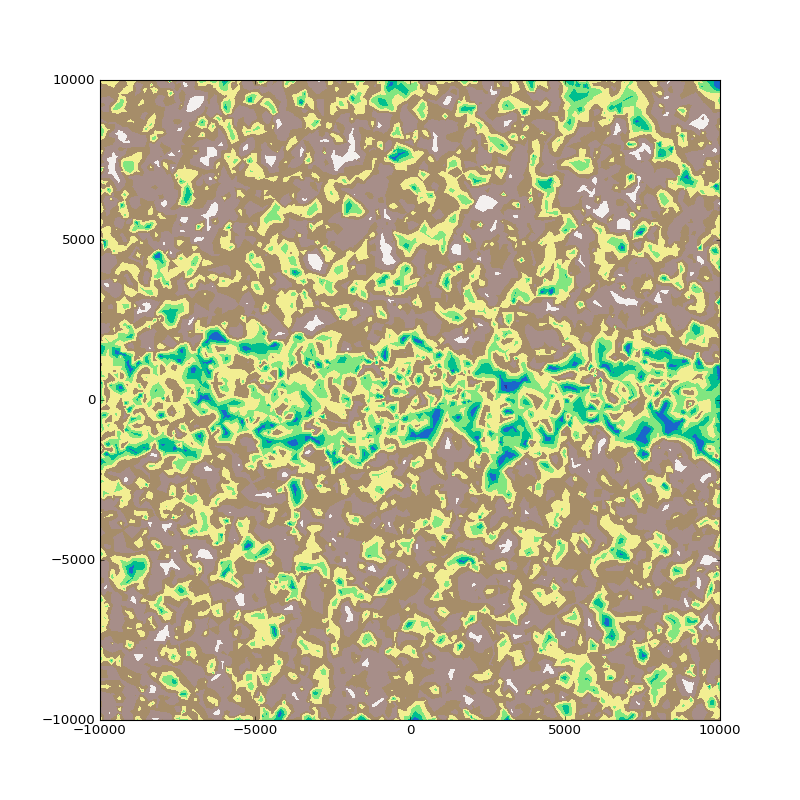

0.0
0


In [231]:
m.draw_map_tri()

In [228]:
m.set_sea()

<IPython.core.display.Javascript object>


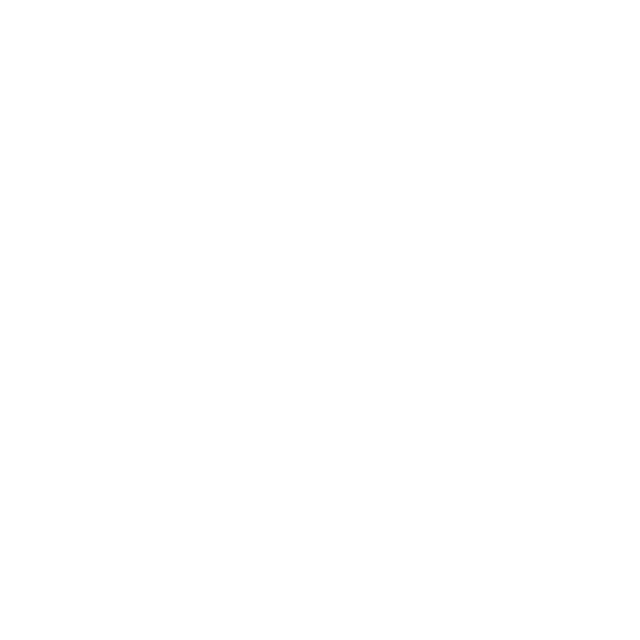

In [120]:
%matplotlib notebook

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

m.draw_model_triangles(ax,h=True)
plt.show()

In [233]:
for i in range(10):
    m.dont_print = True
    m.set_sea()
    m.lakes = []

    m.set_flux()
    #m.dont_print = False
    m.fill_lakes()
    m.dont_print = True
    m.set_flux()

    m.erode_accumulate()

New lakes made in set_flux.
Lakes filled, fluxes are messed up.
New lakes made in set_flux.
Lakes filled, fluxes are messed up.
New lakes made in set_flux.
Lakes filled, fluxes are messed up.
New lakes made in set_flux.
Lakes filled, fluxes are messed up.
New lakes made in set_flux.
Lakes filled, fluxes are messed up.
New lakes made in set_flux.
Lakes filled, fluxes are messed up.
New lakes made in set_flux.
Lakes filled, fluxes are messed up.
New lakes made in set_flux.
Lakes filled, fluxes are messed up.
New lakes made in set_flux.
Lakes filled, fluxes are messed up.
New lakes made in set_flux.
Lakes filled, fluxes are messed up.


<IPython.core.display.Javascript object>


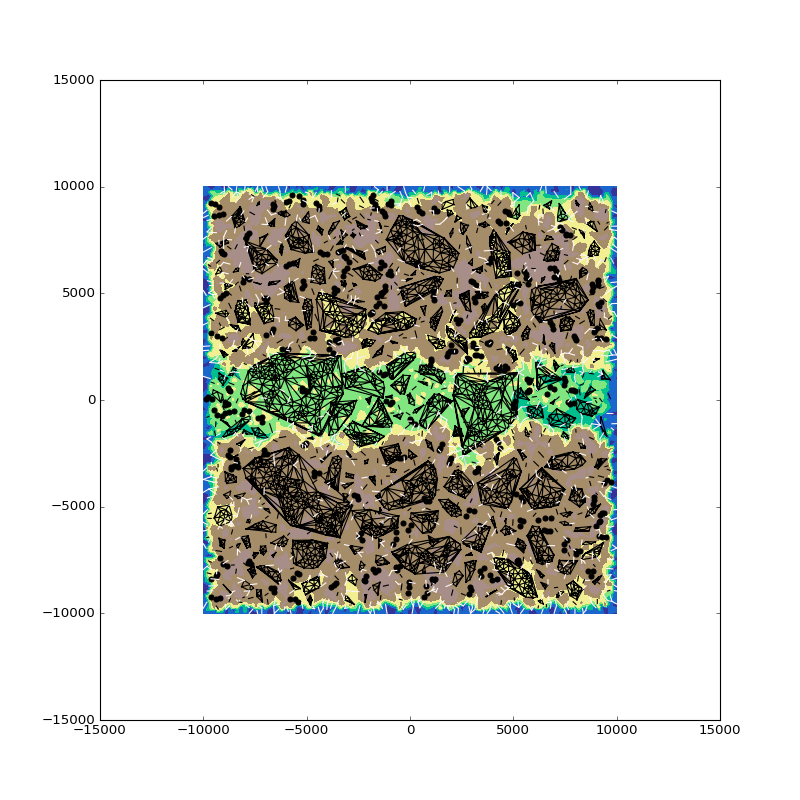

3.024
379


In [234]:
m.draw_map_tri()

<IPython.core.display.Javascript object>


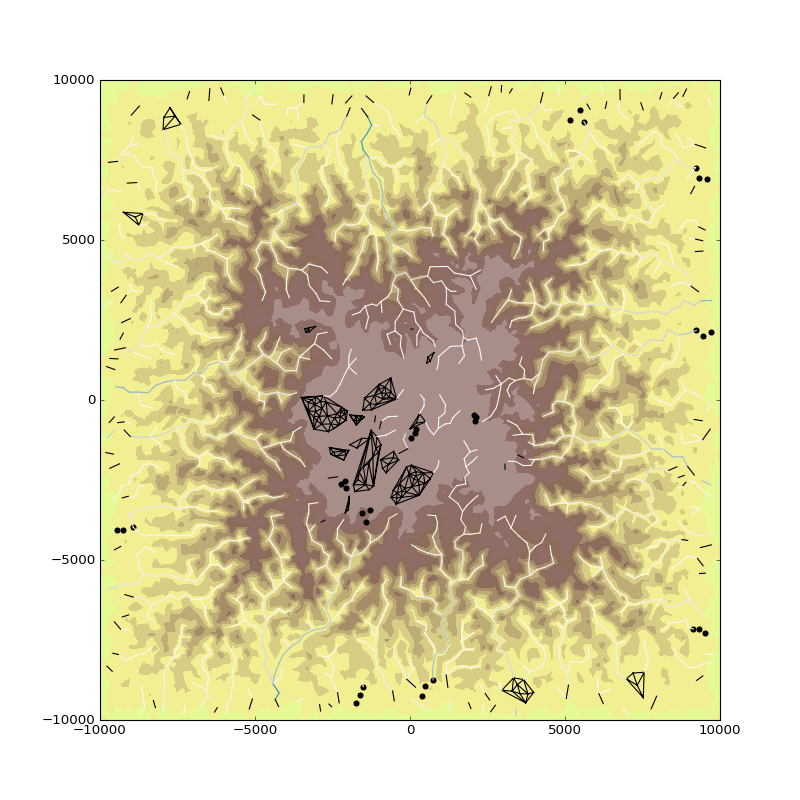

12.2553
953


(-10000, 10000)

In [111]:
m.draw_map_tri()
plt.xlim(xlim)
plt.ylim(ylim)

In [95]:
def printout(lake_n):
    print("boundary nodes:")
    print(m.boundary_nodes)

    print("\n number, h and wl of points")
    for i in m.lakes[lake_n]["points"]:print(i, m.h[i], m.wl[i])
    print("\n i, h, wl of shore")
    for i in m.lakes[lake_n]["shore"]:print(i, m.h[i], m.wl[i])
    print("\ndirection of points")
    for i in m.lakes[lake_n]["points"]:print(m.flux_direction[i])
    for i in m.lakes[lake_n]["points"]:
        print("\n Neighbours of, and their heights", i, m.h[i], m.wl[i])
        for j in m.G.neighbors(i):
            print(j, m.h[j], m.wl[j])
    for i in m.lakes[lake_n]["points"]:
        if i in m.boundary_nodes:
            print("This one is in the boundary and points, ", i)
    for i in m.lakes[lake_n]["shore"]:
        if i in m.boundary_nodes:
            print("This one is in the shore and points, ", i)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
m.draw_model_triangles(ax,h=False)


plt.show()

In [ ]:
#now a function

fig, ax = plt.subplots(figsize = (10,10))
ax.tricontourf(m.X, m.Y, np.array(m.h), triangles = m.T.triangles, edgecolors = "k" ,
               vmin = hlim[0], vmax = hlim[1], cmap = "terrain")
average_river = np.average(m.flux)
print(average_river)
max_river = np.max(m.flux)
min_river = np.min(m.flux)
print(max_river)
norm = mcolors.Normalize(vmin = min_river, vmax = max_river)
colors = cm.ScalarMappable(norm=norm, cmap="PuBu")

for i in m.G.nodes():
    if m.flux[i]>average_river/2:
        j = m.flux_direction[i]
        if i!=-1 and j!=-1:
            ax.plot([m.X[i], m.X[j]], [m.Y[i], m.Y[j]], c = colors.to_rgba(m.flux[i]))
for l in m.lakes:
    x= []
    y =[]
    for i in l["points"]:
        x.append(m.p[i].x)
        y.append(m.p[i].y)
    
    if len(x)>3:
        ax.triplot(x,y, c="k")
    elif len(x)==2:
        ax.plot(x,y, c ="k")
    else:
        ax.scatter(x,y, c ="k")
#triangulation = m.T)#, Z = m.h)
plt.show()


In [ ]:
printout(52)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

#m.draw_model_triangles(ax)
m.draw_model(ax, rstride = 1, cstride = 1, cmap = "terrain")
ocean = []
ocean = m.ocean["points"]
x, y, z = [], [], []
for i in ocean:
    x.append(m.X[i])
    y.append(m.Y[i])
    z.append(1000)
"""for l in m.lakes:
    for i in l["points"]:
        x.append(m.X[i])
        y.append(m.Y[i])
        z.append(5)"""
ax.scatter(x,y,z)
plt.show()

In [ ]:
for i in range(100):
    m.set_flux_and_lakes()
    m.erode_accumulate()

In [ ]:
m.draw_model_triangles()
plt.figaspect(1)
plt.show()

In [ ]:
len(m.lakes)

In [ ]:
m.draw_map_h()

In [ ]:
m.draw_map_wl()

In [ ]:
np.max(m.flux)/np.average(m.flux)
